In [1]:
# !pip install optuna -q
import pandas as pd
import numpy as np 
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 100

/Users/sunandclouds/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Onehot encoding

In [2]:
file_path = 'training_data.csv'
data = pd.read_csv(file_path)
data['increase_stock_binary'] = data['increase_stock'].map(lambda x: 0 if x == 'low_bike_demand' else 1)
data = data.drop(['snow', 'increase_stock'], axis=1)

# pick out the labels
y = data['increase_stock_binary'].to_numpy().astype(np.float32)
y = torch.tensor(y).unsqueeze(-1)
data = data.drop(['increase_stock_binary'], axis=1)

# Separating the numerical and categorical data to handle them separately
cat_data = pd.DataFrame({key:data[key] for key in data.keys() if data[key].dtype == int})
num_data = pd.DataFrame({key:data[key] for key in data.keys() if data[key].dtype == float})

# performing onehot encoding on the categorical data
cat_data = torch.from_numpy(cat_data.to_numpy())
cat_onehot = torch.cat([F.one_hot(x, num_classes=24) for x in cat_data]).view(cat_data.shape[0], -1)

# constructing the complete input dataset
data = np.concatenate([num_data.to_numpy(), cat_onehot.numpy()], axis=-1).astype(np.float32)

# scaling
X = MinMaxScaler().fit_transform(data) 
X = torch.tensor(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1200, 152]) torch.Size([400, 152]) torch.Size([1200, 1]) torch.Size([400, 1])


## DNN
With batch normalization and residual connection.

In [3]:
class DNN(nn.Module):
    def __init__(self, hidden_size, input_size, layers=2, seed=0, submodule=False):
        super().__init__()
        torch.manual_seed(seed)
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.submodule = submodule
        
        self.activation = nn.ReLU()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.batch_norm_input = nn.BatchNorm1d(hidden_size)  # BatchNorm for input layer
        self.linear_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()  # BatchNorm for other layers

        for _ in range(layers):
            self.linear_layers.append(nn.Linear(hidden_size, hidden_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        self.output_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.batch_norm_input(x)
        x = self.activation(x)

        for layer, batch_norm in zip(self.linear_layers, self.batch_norm_layers):
            residual = x
            x = layer(x)
            x = batch_norm(x)  
            x = self.activation(x + residual)
        
        if not self.submodule:
            x = self.output_layer(x)
            x = torch.sigmoid(x) 
        return x

## Training loop

100%|██████████| 100/100 [00:00<00:00, 155.38it/s]


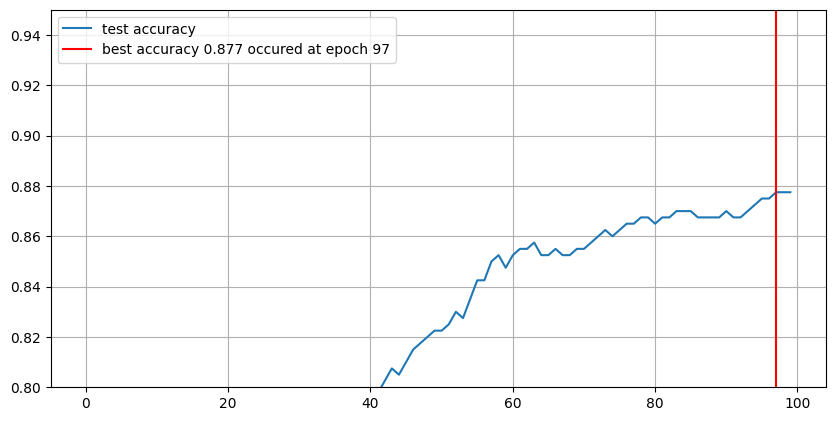

In [4]:
epochs = 100
metric = lambda prediction, label: (prediction.round() == label).numpy().mean()
loss_fn = torch.nn.BCELoss() 

model = DNN(17, X_train.shape[-1], 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_history = []
test_loss_history = []
test_metric_history = []

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    train_loss_history.append(loss.item())
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_loss = loss_fn(y_pred_test, y_test)
        test_loss_history.append(test_loss.item())
        accuracy = metric(y_pred_test, y_test)
        if len(test_metric_history) > 0 and accuracy > max(test_metric_history):
            optimal_epoch = epoch
        test_metric_history.append(accuracy)
        
    
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(test_metric_history, label="test accuracy")
plt.axvline(
    optimal_epoch,
    color="red", 
    label=f"best accuracy {test_metric_history[optimal_epoch]:.3f} occured at epoch {optimal_epoch}")
plt.ylim(0.8, 0.95)
plt.legend(), plt.grid()
plt.show()

## k-fold cross validation

In [5]:
epochs = 100 
loss_fn = nn.BCELoss()
n_ensembles = 10 # checking the performance for different weight initialization
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
optimal_models = []

for n in range(n_ensembles):
    fold_performance = []
    for cv, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        model = DNN(200, X.shape[-1], 2, seed=n)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1)
        
        train_loss_history = []
        test_loss_history = []
        test_metric_history = []
        optimal_weights = 0
        
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            model.train()
            y_pred = model(X_train[train_index])
            loss = loss_fn(y_pred, y_train[train_index])
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                model.eval()
                y_pred_test = model(X_train[test_index])
                test_loss = loss_fn(y_pred_test, y_train[test_index])
                test_loss_history.append(test_loss.item())
                accuracy = metric(y_pred_test, y_train[test_index])

                if len(test_metric_history) > 0 and accuracy > max(test_metric_history):
                    optimal_epoch = epoch
                    optimal_weights = model.state_dict()
                test_metric_history.append(accuracy)

            train_loss_history.append(loss.item())
        optimal_models.append(optimal_weights)  
        fold_performance.append(test_metric_history[optimal_epoch])
        
    mean_performance = np.mean(fold_performance)
    print(f"{optimal_epoch=}")
    print(f"Mean performance for ensemble {n}: {mean_performance:.3f} $\pm$ {np.std(fold_performance).round(3)}")
    print(f"{np.round(fold_performance, 3)}")

100%|██████████| 100/100 [00:01<00:00, 61.16it/s]


optimal_epoch=86
Mean performance for ensemble 0: 0.893 $\pm$ 0.025
[0.896 0.904 0.933 0.862 0.871]


100%|██████████| 100/100 [00:01<00:00, 62.19it/s]


optimal_epoch=87
Mean performance for ensemble 1: 0.907 $\pm$ 0.01
[0.892 0.912 0.908 0.921 0.904]


100%|██████████| 100/100 [00:01<00:00, 61.96it/s]


optimal_epoch=94
Mean performance for ensemble 2: 0.903 $\pm$ 0.009
[0.9   0.904 0.917 0.904 0.888]


100%|██████████| 100/100 [00:01<00:00, 62.56it/s]


optimal_epoch=96
Mean performance for ensemble 3: 0.905 $\pm$ 0.008
[0.908 0.908 0.917 0.892 0.9  ]


100%|██████████| 100/100 [00:01<00:00, 62.31it/s]


optimal_epoch=86
Mean performance for ensemble 4: 0.904 $\pm$ 0.014
[0.9   0.917 0.925 0.888 0.892]


100%|██████████| 100/100 [00:01<00:00, 62.29it/s]


optimal_epoch=96
Mean performance for ensemble 5: 0.893 $\pm$ 0.014
[0.875 0.904 0.912 0.883 0.888]


100%|██████████| 100/100 [00:01<00:00, 61.87it/s]


optimal_epoch=87
Mean performance for ensemble 6: 0.895 $\pm$ 0.012
[0.892 0.896 0.917 0.888 0.883]


100%|██████████| 100/100 [00:01<00:00, 61.88it/s]


optimal_epoch=98
Mean performance for ensemble 7: 0.901 $\pm$ 0.02
[0.921 0.912 0.917 0.875 0.879]


100%|██████████| 100/100 [00:01<00:00, 62.15it/s]


optimal_epoch=83
Mean performance for ensemble 8: 0.898 $\pm$ 0.009
[0.892 0.896 0.917 0.896 0.892]


100%|██████████| 100/100 [00:01<00:00, 61.65it/s]

optimal_epoch=88
Mean performance for ensemble 9: 0.900 $\pm$ 0.011
[0.892 0.912 0.912 0.896 0.888]


## Evaluation using precision and recall

In [6]:
def compute_precision(predictions, labels, positive_label=1):
    TP = ((predictions == positive_label) & (labels == positive_label)).sum().item()
    FP = ((predictions == positive_label) & (labels != positive_label)).sum().item()
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def compute_recall(predictions, labels, positive_label=1):
    TP = ((predictions == positive_label) & (labels == positive_label)).sum().item()
    FN = ((predictions != positive_label) & (labels == positive_label)).sum().item()
    return TP / (TP + FN) if (TP + FN) > 0 else 0


def DeepNeuralNetworkEnsemble(optimal_models, test_data):
    DNN_ensemble = []
    for weights in optimal_models:
        model = DNN(200, X.shape[-1], 2)
        model.load_state_dict(weights)
        y_pred = model(test_data)
        DNN_ensemble.append(y_pred.detach().numpy())
    return torch.Tensor(DNN_ensemble).mean(0).round()
    
prediction = DeepNeuralNetworkEnsemble(optimal_models, X_test)
accuracy = metric(prediction, y_test)

print(round(accuracy, 2))
for positive_label in [0, 1]:
    recall = compute_recall(prediction, y_test, positive_label)
    precision = compute_precision(prediction, y_test, positive_label)
    print(round(precision, 2), round(recall, 2))

0.9
0.93 0.94
0.74 0.71


<ipython-input-6-87f8ad012e2b>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  return torch.Tensor(DNN_ensemble).mean(0).round()


Text(0.5, 0, 'Accuracy')

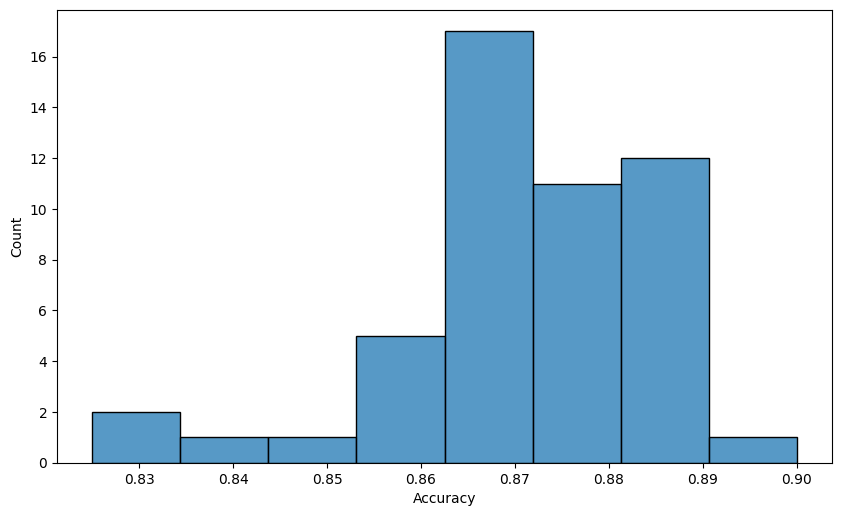

In [7]:
single_DNN_performance = []
for weights in optimal_models:
    model = DNN(200, X.shape[-1], 2)
    model.load_state_dict(weights)
    y_pred = model(X_test)
    single_DNN_performance.append(metric(y_pred, y_test))

plt.figure(figsize=(10, 6), dpi=100)
sns.histplot(single_DNN_performance)
plt.xlabel("Accuracy")
#plt.savefig("Accuracy distribution for DNN ensemble", bbox_inches="tight")